# 2019 Winter STAT 231B Homework 4: XGBoost
In this assignment, you will implement xgboost for an email spam dataset. This dataset has 57 continuous predictors and 1 nominal class label, {0, 1}. 
- Use negative log-likelihood loss with label {0, 1}.
- You don't need to consider regularization for the xgboost. However we ask you to grow a tree with `sklearn.tree.DecisionTreeRegressor`. It allows you to set parameter `min_impurity_decrease` which is somewhat equivalent to regularize the number of trees in a model. For more details, see https://xgboost.readthedocs.io/en/latest/tutorials/model.html. If you don't understand the equivalance, that's fine. Just implement xgboost without regularization and grow a tree with tuning in `min_impurity_decrease` parameter for `sklearn.tree.DecisionTreeRegressor`. Of course, you can implement a regression function to grow a tree by yourself. Then it's convenienent to do any regularization for xgboost, which is not reuqired for this homework.
- Please follow the notebook to fill in the code required in four parts.
- The output we would like to see is a plot of cross-valition accuracy as a function of hyparameters and the accuracy of the testing data. If you implement the regression tree function by yourself instead of using `sklearn.tree.DecisionTreeRegressor`, just plot the accuracy over the hyperparameters you define.
- Please complete this notebook and print it out as pdf for submission. Submit 2 files, one pdf and one python files (python file need fill only boost class and cross_validation function).

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D

# load data 
data = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
p_ = data.shape[1]
p = p_ - 1
X = data.iloc[:, :p]
y = data.iloc[:, p]

# split the data to training set and testing test
# the training set will be used to choose hyperparameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

## XGBoost Implementation
Define a function or class to implement the xgboost. To grow a tree, you can `sklearn.tree.DecisionTreeRegressor` directly. It allows you to set sample_weight which comes handy for growing a tree in xgboost since each step 
of xgboost is essentially building a regression tree with sample weight. 'sklearn.tree.DecisionTreeRegressor' also enables you to set `min_impurity_decrease` (A node will be split if this split induces a decrease of the impurity greater than or equal to this value.). Please use this parameter to control the complexity of the tree. This parameter is considered as a hyperparameter for our boosting model. The number of trees of the boosting model, M, is also considered as a hyperparameter.


In [13]:
# define a function or class to implement the xgboost here
#########################################################
# fill in code here

class XGBOOST():
    def __init__(self, min_impurity_decrease=0.01, M=5):
        self.min_impurity_decrease = min_impurity_decrease
        self.M = M

    def training(self, train_features, train_labels):
        n = train_features.shape[0]
        self.trees = {}
        # 1st tree
        self.trees[0] = DecisionTreeRegressor(min_impurity_decrease=self.min_impurity_decrease)
        self.trees[0].fit(train_features, train_labels-np.mean(train_labels))
        s = self.trees[0].predict(train_features)
        
        for i in np.arange(1,self.M):
            p = np.exp(s) / (1+np.exp(s))
            r = train_labels - p
            a = np.exp(s) / np.square(1+np.exp(s)) + 0.0001
            new_y = r / a
            self.trees[i] = DecisionTreeRegressor(min_impurity_decrease=self.min_impurity_decrease)
            self.trees[i].fit(train_features, new_y, sample_weight=a)
            s_update = self.trees[i].predict(train_features)
            s += s_update
            
    def testing(self, test_features, test_labels):
        n = test_features.shape[0]
        s_pred = np.zeros(test_labels.shape)
        y_pred = np.zeros(test_labels.shape)
        
        for i in self.trees.keys():
            s_update = self.trees[i].predict(test_features)
            s_pred += s_update
        
        pred_prob = np.exp(s_pred) / (1+np.exp(s_pred)) 
        y_pred[pred_prob >= (1-pred_prob)] = 1
        
        acc_test = np.mean(y_pred == test_labels)
            
        return acc_test
#########################################################

## Cross Validation
Define a function to do cross-validation to search for hyperparameter values with training set and the xgboost implementation above. This function has three input parameters. 1. log_min_impurity_decreases: a list consists of min_impurity_decrease on a log scale. 2. Ms: a list consists of the number of trees that a boosting model has. 3. n_splits: the folds for cross-validation. The purpose of the function is to tune in min_impurity_decrease and M. To choose hyperparameters we use data (X_train, y_train).

This function returns three objects:
- 1 plot_values is a numpy.array with three columns where the first column is log_min_impurity_decrease, the second column is M, and the third column is the corresponding mean accuracy of each cross-validation
- 2 best_log_min_impurity_decrease: the best log_min_impurity_decrease
- 3 best_M: the best M
- best_log_min_impurity_decrease and best_M are determined by the highest average accuracy


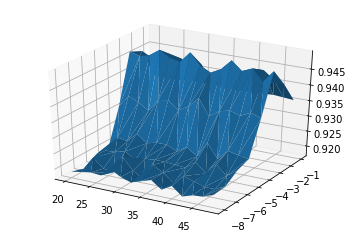

In [14]:
def cross_validation(log_min_impurity_decreases, Ms, n_splits=5):
    #########################################################
    kf = KFold(n_splits=n_splits)
    plot_values = np.zeros(shape=(len(log_min_impurity_decreases)*len(Ms),3))
    for M in Ms:
        for imp in log_min_impurity_decreases:
            xgb = XGBOOST(M=M, min_impurity_decrease = 10**imp)
            acc_cv = 0
            for i, (train_ind, test_ind) in enumerate(kf.split(X_train,y_train)):
                X_train_cv = X_train[train_ind,:]
                y_train_cv = y_train[train_ind]
                X_test_cv = X_train[test_ind,:]
                y_test_cv = y_train[test_ind]
                xgb.training(X_train_cv, y_train_cv)
                acc_test = xgb.testing(X_test_cv, y_test_cv)
                acc_cv += acc_test            
            acc_cv /= n_splits                
            plot_values[Ms.index(M)*len(log_min_impurity_decreases)+log_min_impurity_decreases.index(imp), 0] = M
            plot_values[Ms.index(M)*len(log_min_impurity_decreases)+log_min_impurity_decreases.index(imp), 1] = log_min_impurity_decreases[imp]
            plot_values[Ms.index(M)*len(log_min_impurity_decreases)+log_min_impurity_decreases.index(imp), 2] = acc_cv  
    best_ind = np.where(plot_values[:,2]==np.max(plot_values[:,2]))
    best_M = plot_values[best_ind,0]
    best_log_min_impurity_decrease = plot_values[best_ind,1]
    return plot_values, best_log_min_impurity_decrease, best_M

log_min_impurity_decreases = list(range(-8, 0))
Ms = list(range(20, 50, 2))
plot_values, best_log_min_impurity_decrease, best_M = cross_validation(log_min_impurity_decreases=log_min_impurity_decreases, Ms=Ms)

# plot the accuracy over the hyperparameter values
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(plot_values[:, 0], plot_values[:, 1], plot_values[:, 2], linewidth=0.2, antialiased=True)
plt.show()

## Fit the training data with the chosen hyperparameters
Use data (X_train, y_train)




In [17]:
xgb = XGBOOST(min_impurity_decrease=10**(best_log_min_impurity_decrease), M=best_M)
xgb.training(X_train,y_train)
acc_train = xgb.testing(X_train, y_train)
print('the training accuracy is', acc_train)

the training accuracy is 0.9997282608695652


## Print the testing accuracy with the chosen models
Use data (X_test, y_test)

In [16]:
acc_test = xgb.testing(X_test,y_test)
print('the testing accuracy is', acc_test)

the testing accuracy is 0.9391965255157437
